In [1]:
# Evaluation DPC Image data from OMICS V3 randomized plates for Day 21 imaging of Group 1
# and spits out plots on density and percent neurite coverage

In [82]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import anndata as ad

In [83]:
### Load in dfs and attach plate and timepoint metadata
# Define the path to the directory containing the folders
directory_path = "NMDA36Linesd17HarmonyAnalysis"

# Get a list of all the folders in the directory
folders = os.listdir(directory_path)

In [84]:
## Rosies compound hack (used in next cell)
def ret_string_if_exists(lst):
    matches_self = [x for x in lst if x==x]
    if len(matches_self) > 0:
         return matches_self[0]
    else:
        return np.nan

In [85]:
### Extract DPC Data from all plates all timepoints (requires insitro network access)
all_data = pd.DataFrame()

# Metadata URL for Platemapper CSV output
url = "https://data-api.aws.insitro.com/api/v1/plate_metadata/?plate_barcode=#&format=csv"

# Loop over each folder in the list
for folder in folders:
    # Construct the path to the Evaluation1 folder in this folder
    eval1_path = os.path.join(directory_path, folder, "Evaluation1")    
    
    # Check if the Evaluation1 folder exists in this folder
    if os.path.exists(eval1_path):
        # Construct the path to the PlateResults.txt file
        results_path = os.path.join(eval1_path, "PlateResults.txt")
        
        # Load the PlateResults.txt file into a pandas dataframe
        df = pd.read_csv(results_path, sep="\t", skiprows = 8)
        
        # Find PlateID from folder name and pull metadata from API
        plate_id = folder.split("_", 2)[0]
        df["PlateID"] = plate_id
        ret = requests.get(url.replace("#", plate_id))
        meta_df = pd.read_csv(StringIO(ret.content.decode('utf8')))

        # Drop rows that are duplicate for compound reasons (req. Rosie's)
        meta_df = meta_df.groupby(['barcode','well_position']).agg(ret_string_if_exists).reset_index()
        
    # Merge metadata with df 
        df["well_position"] = [chr(ord("A") -1 + int(row["Row"])) + str(int(row["Column"])) for _, row in df.iterrows()]
        # Merge metadata
        df = pd.merge(meta_df, df, on=['well_position'],)
        df = df.dropna(subset=['cell_line_instances_cell_line_registry_id'])
        
        #Add Timepoint Column
        df["Timepoint"] = folder.split("_", 2)[1]
        
        # Concatenate all dfs together for master dataset
        all_data = pd.concat([all_data, df])
        
# Check for metadata alignment in all_data
#all_data[['cell_line_instances_cell_line_registry_id', 'well_position' , 'compound_instances_compound_name']]        

In [86]:
# Shorten Compound names
all_data['compound_instances_compound_name'] = all_data['compound_instances_compound_name'].replace('N-Methyl-D-aspartic Acid, Hydrate [MilliporeSigma]', 'NMDA')
all_data['compound_instances_compound_name'].fillna("DMSO", inplace=True)
set(all_data['compound_instances_compound_name'])


{'DMSO', 'NMDA'}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


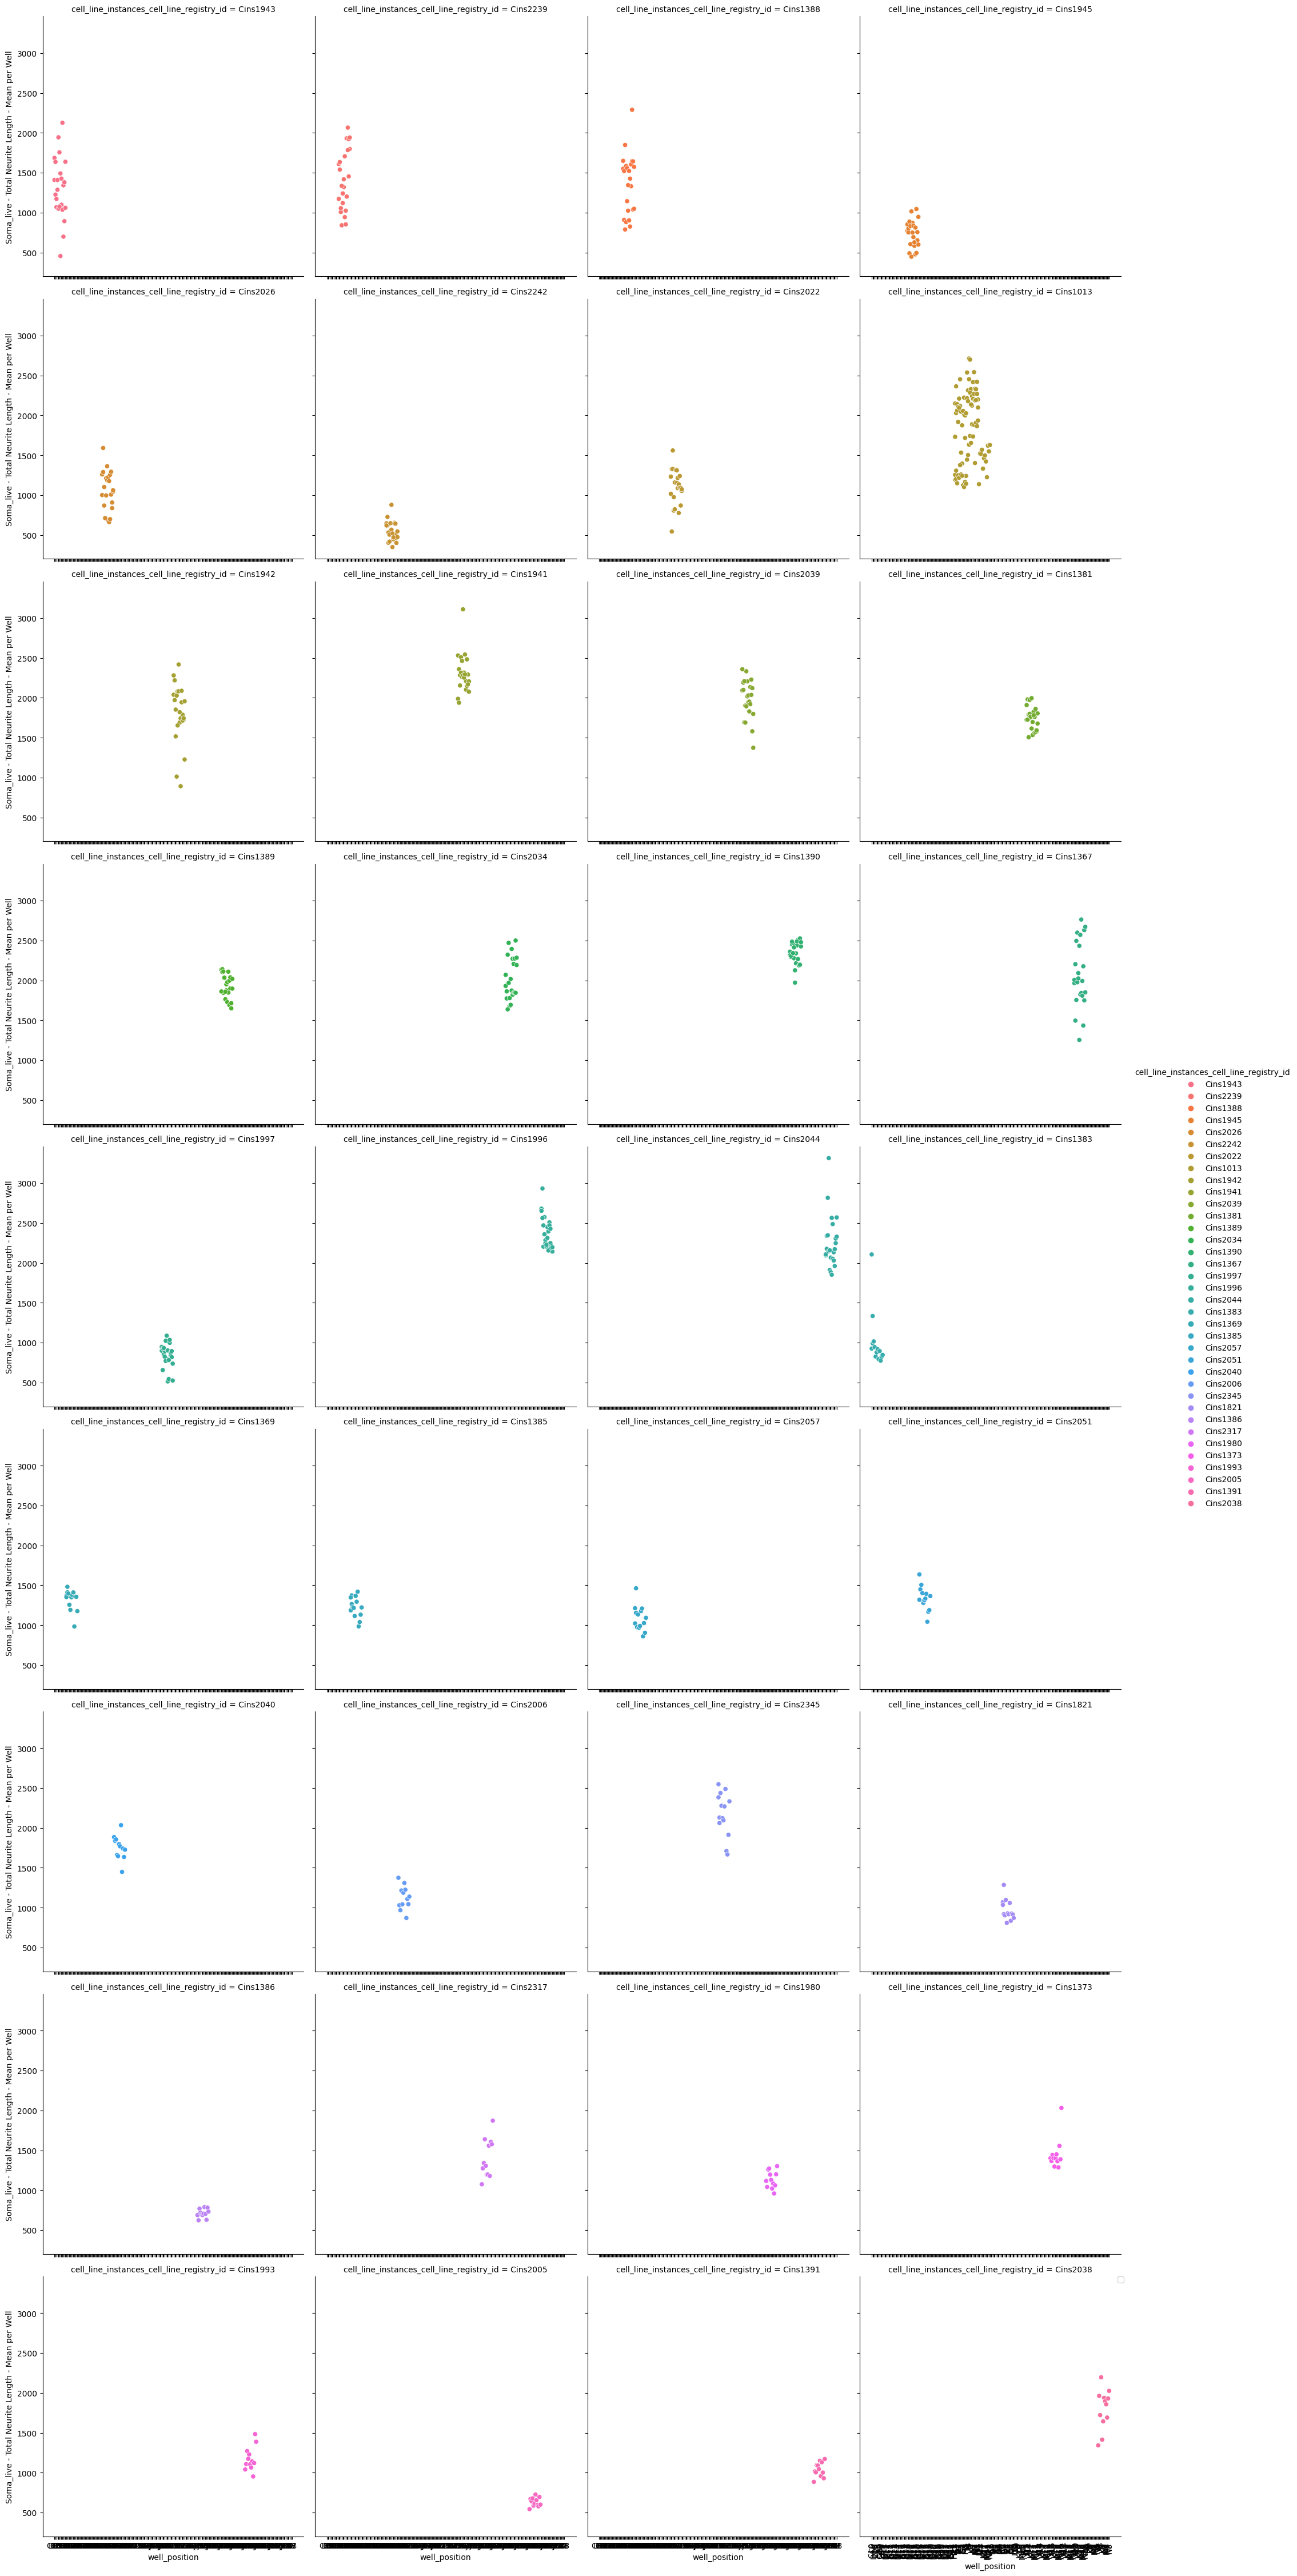

In [87]:
# QC of wells: in T0 round (DIV17 before treatment and remove outliersbefore proceeding with analysis
# Plot all_data number of objects and remove outlier wells.
# Plot 'Soma_live - Total Neurite Length - Mean per Well' by 'well_position'
df_t1 = all_data.loc[all_data['Timepoint'] == 'DIV17']
sns.relplot(x='well_position', y='Soma_live - Total Neurite Length - Mean per Well', hue='cell_line_instances_cell_line_registry_id', data=df_t1, col='cell_line_instances_cell_line_registry_id', col_wrap=4)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0, ncol=2)
plt.show()

In [88]:
##FILTER# outlier cells (not finished)
#all_data = all_data[(all_data['Soma_live - Number of Objects'] >= 450) & (all_data['Soma_live - Number of Objects'] <= 3000)]

In [113]:
### T0 Normalization, separate out each plate and divide each datapoint with its matching T0 value at each well.
# load data
# Load csv here
# Create empty df for plot
plot_df = pd.DataFrame()

# Add y parameter here:
assay = ['Soma_live - Number of Objects'] #Edit this bracket with column name associated with metric. list(all_data) will show you your options.

# Add Metadata columns here:
metadata = ['PlateID','Timepoint','well_position','cell_line_instances_cell_line_registry_id', 'compound_instances_compound_name','cell_line_instances_donor.registry_id','cell_line_instances_cell_line_edit_description']

# List plates and timepoints
plates = set(all_data['PlateID'])
timepoints = all_data['Timepoint'].unique()

# Subset the data by assay and merge by well position in normalized df
for plate in plates:
    data = all_data.loc[all_data['PlateID'] == plate]
    df_t1 = data.loc[data['Timepoint'] == 'DIV17', assay + metadata]
    plate_df = df_t1[metadata]
    plate_df = plate_df.drop('Timepoint', axis=1)
    
    for timepoint in timepoints:
        df_timepoint = data.loc[data['Timepoint'] == timepoint, assay + ['well_position']]
        df_timepoint = pd.merge(df_timepoint[assay + ['well_position']], df_t1[assay + ['well_position']], on='well_position', suffixes=('', '_match'))
        # Divide each well by T0 of same well
        df_timepoint.insert(3, timepoint, df_timepoint.iloc[:, 0] / df_timepoint.iloc[:, 2])

        # Compile final platedf
        plate_df = pd.merge(df_timepoint[[timepoint] + ['well_position']], plate_df, on=['well_position'],)
        
    # Update the final with the normalized values and add index
    plot_df = pd.concat([plate_df, plot_df])

# Rearrange Columns
plot_df = plot_df[['DIV17', '8HPost', '24HPost','48HPost', '72HPost', '102HPost', '124HPost', '168HPost','cell_line_instances_cell_line_edit_description', 'well_position' ,'PlateID', 'cell_line_instances_cell_line_registry_id',  'cell_line_instances_donor.registry_id', 'compound_instances_compound_name']]
# Create a new column with the unique combination of "donor" and "gene edit"
plot_df['donor_and_gene'] = plot_df['cell_line_instances_donor.registry_id'] + ' ' + plot_df['cell_line_instances_cell_line_edit_description']


# Save normalized sheet for each assay
plot_df.to_csv("T0 Normalized_Filtered" + str(assay), index=False)
    

In [115]:
list(timepoints)

['8HPost',
 '72HPost',
 '24HPost',
 '48HPost',
 '168HPost',
 '102HPost',
 '124HPost',
 'DIV17']

In [137]:
### Plot timecouse
labels = ['cell_line_instances_cell_line_edit_description', 'cell_line_instances_cell_line_registry_id', 'compound_instances_compound_name']
timepoints = timepoints
assay = assay

# Melt the label and timepoint columns to one column each
melted_df = pd.melt(plot_df, id_vars=labels, value_vars=timepoints, var_name='Timepoint', value_name="value")
melted_df = melted_df.dropna(subset=["value"])

NameError: name 'plot' is not defined

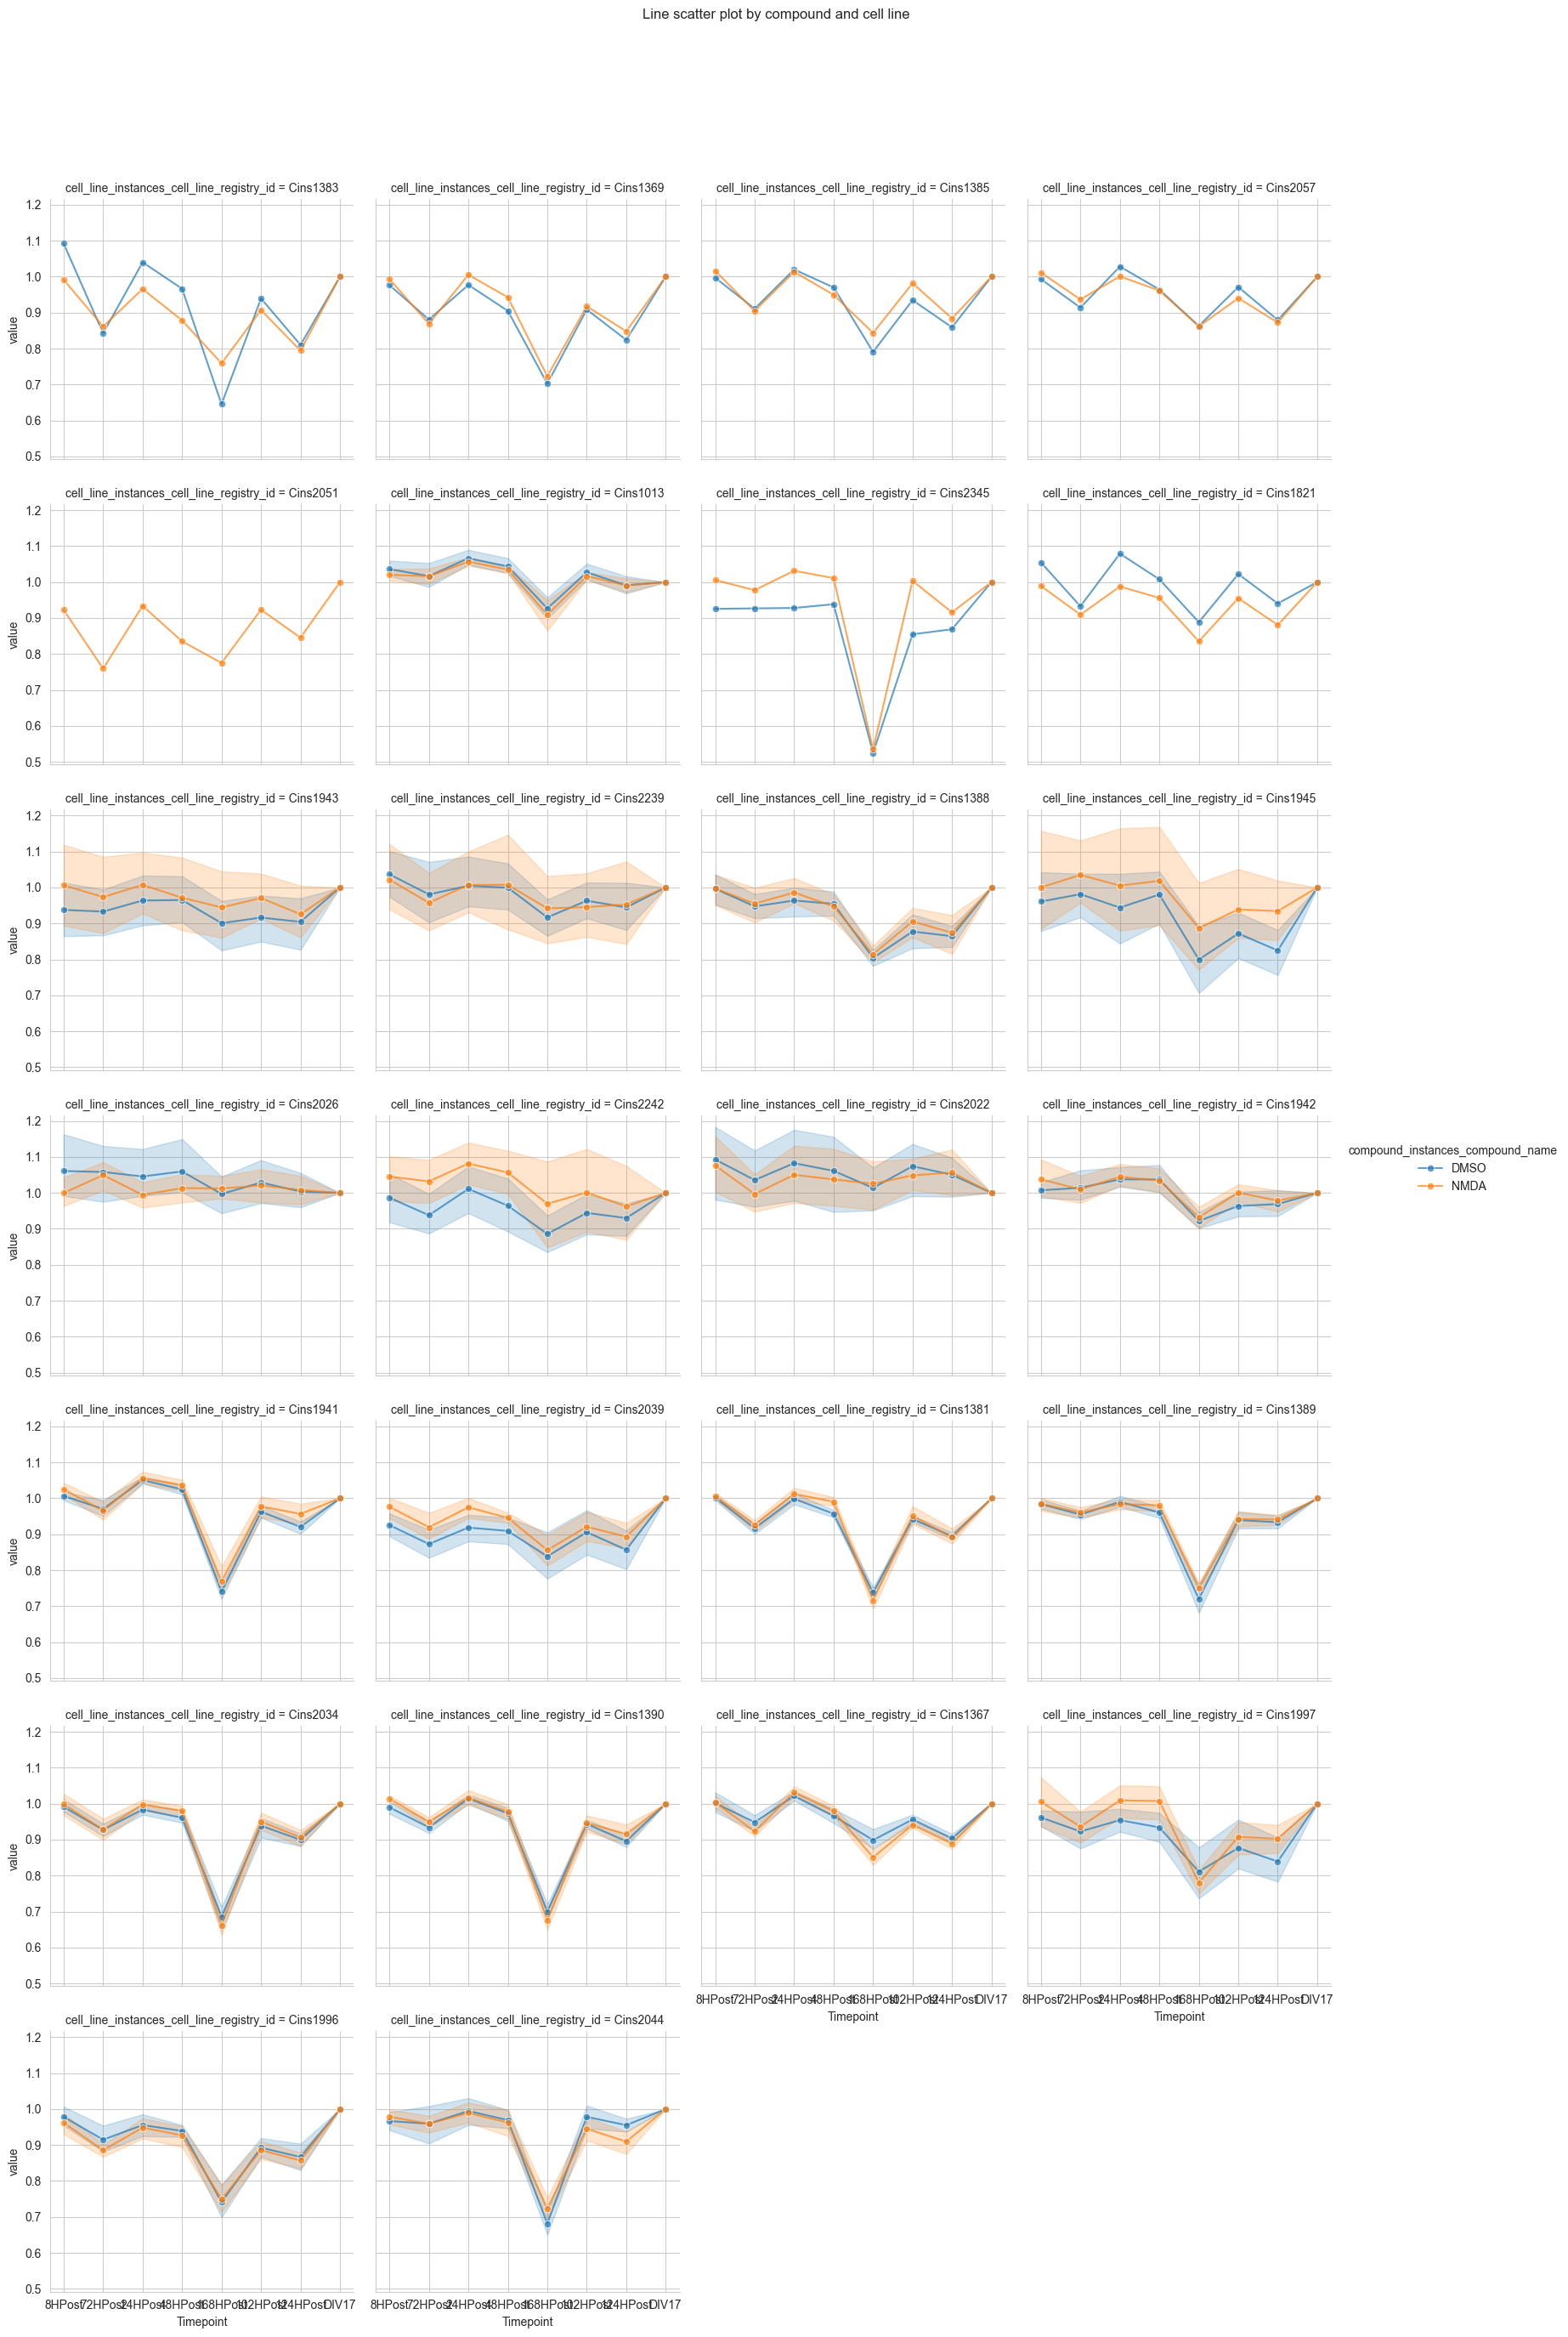

In [142]:
# Do Some plotting

# Define the plot
sns.set_style("whitegrid")
g = sns.FacetGrid(melted_df, col="cell_line_instances_cell_line_registry_id", hue="compound_instances_compound_name",
                  col_wrap=4, height=4)

# Create the plot with aggregated values by "Timepoint" for x-axis and "y" column
g = (g.map(sns.lineplot, "Timepoint", "value", marker="o", alpha=0.7).add_legend())

# Show the plot
sns.despine()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Line scatter plot by compound and cell line")